<a href="https://colab.research.google.com/github/PuChan-HCI/myweb/blob/main/MediaSystem/ImageProcessing04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. 画像認識 (Image Recognition)



### a. テンプレートマッチング  (Template Matching)

In [13]:
import urllib.request
url1 = 'https://raw.githubusercontent.com/PuChan-HCI/myweb/main/MediaSystem/eye.jpg'
eye = 'eye.jpg'
urllib.request.urlretrieve(url1, eye)
url2 = 'https://raw.githubusercontent.com/PuChan-HCI/myweb/main/MediaSystem/Einstein.jpg'
face = 'face.jpg'
urllib.request.urlretrieve(url2, face)

('face.jpg', <http.client.HTTPMessage at 0x7e43ad1c9000>)

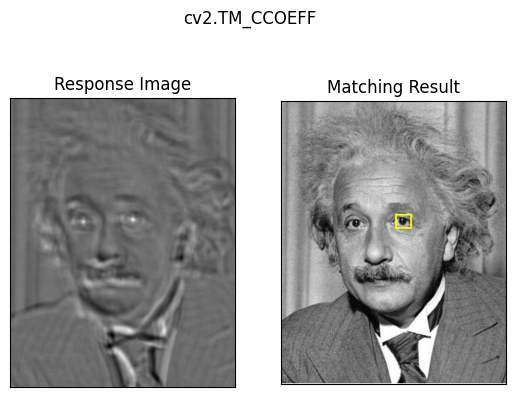

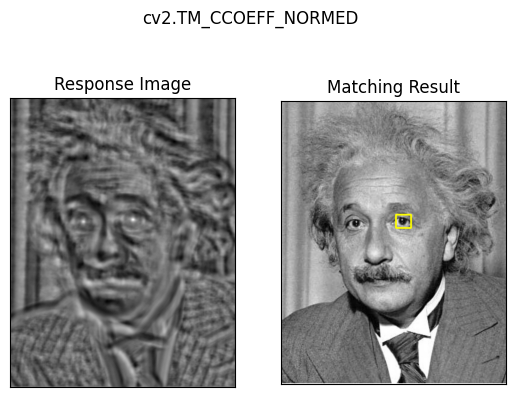

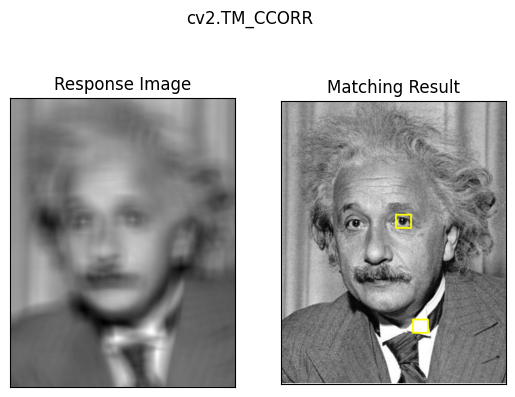

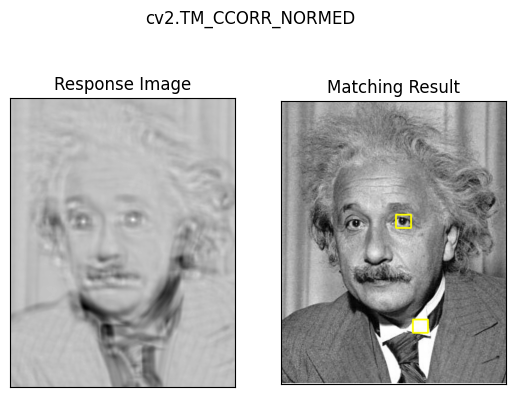

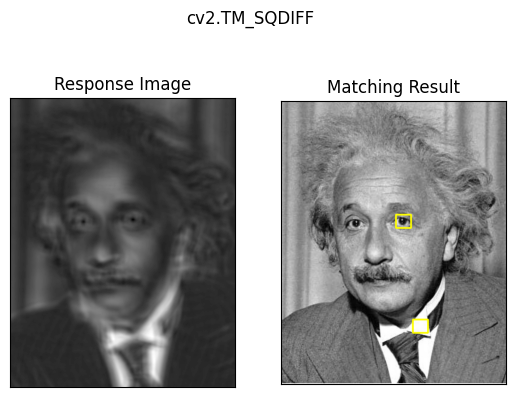

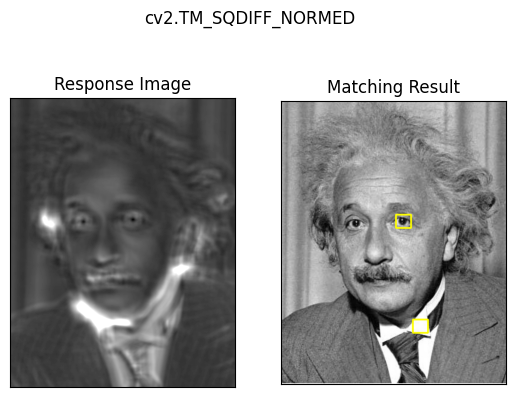

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 画像を読み込み
org = cv2.imread('face.jpg',0)  # '0': load as a grayscale image
gray = org.copy()
color = cv2.cvtColor(org, cv2.COLOR_GRAY2RGB) # カラー表示用
template = cv2.imread('eye.jpg',0)  # Template imaga
w, h = template.shape[::-1]

# 6つのマッチング方法
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = gray.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(color,top_left, bottom_right, (255, 255, 0), 3)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Response Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(color)
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

### b. MeanSift
Since video cannot be processed in real time, the results are output to video before display.

動画をリアルタイム処理できないため，いったん結果を動画に出力してから表示する．

In [12]:
import urllib.request
url = 'https://raw.githubusercontent.com/PuChan-HCI/myweb/main/MediaSystem/CruiseSmall.mp4'
cruise = 'CruiseSmall.mp4'
urllib.request.urlretrieve(url, cruise)

('CruiseSmall.mp4', <http.client.HTTPMessage at 0x7e43e15a75e0>)

In [3]:
# Or upload your own file
# from google.colab import files
# cruise = files.upload()

Saving CruiseSmall.mp4 to CruiseSmall.mp4


In [4]:
# import modules
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

# open file
cap = cv2.VideoCapture('CruiseSmall.mp4')

# get FPS of input video
fps = cap.get(cv2.CAP_PROP_FPS)

# define VideoWriter object
output_file = 'result_meansift.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
rec = cv2.VideoWriter(output_file, fourcc, fps,
                      (int(cap.get(3)), int(cap.get(4))))

# 探索窓の初期位置、大きさ
rct = (170, 270, 50, 50)

# MeanShiftの収束条件
cri = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

while cap.isOpened():
  th = 100
  ret, frame = cap.read()
  if ret == False:
    break
  img_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  ret, img_bin = cv2.threshold(img_g, th, 255, cv2.THRESH_BINARY)

  # MeanShift
  ret, rct = cv2.meanShift(img_bin, rct, cri)

  # CamShift
  # ret, rct = cv2.CamShift(img_bin, rct, cri)

  # 探索窓を四角形で表示
  x, y, w, h = rct
  cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),3)

  # 1フレーム書き込み
  rec.write(frame)

  # キー入力待機（30 ms）。Escキーで中断。
  # if cv2.waitKey(30) == 27:
  #   break
cap.release()
rec.release()
cv2.destroyAllWindows()

In [6]:
# ビデオのフォーマット変換
!ffmpeg -i result_meansift.mp4 -vcodec vp9 out_meansift.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [7]:
# ビデオを表示
from IPython.display import HTML
import base64
import io

def play(file_path):
    video = io.open(file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="640" height="360" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('out_meansift.webm')

### c. CamSift

In [9]:
# MeanSiftの結果を出力するプログラム例
# ------------------------------------
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 動画を開く
cap = cv2.VideoCapture('CruiseSmall.mp4')
ret, frame = cap.read()                           # フレームの取得

# ビデオファイルの保存設定
rec = cv2.VideoWriter('result_camsift.mp4',
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      30, (640, 360))

# 探索窓の初期位置、大きさ
rct = (170, 270, 50, 50)

# MeanShiftの収束条件
cri = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

while(True):
  th = 100
  ret, frame = cap.read()
  if ret == False:
    break
  img_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  ret, img_bin = cv2.threshold(img_g, th, 255, cv2.THRESH_BINARY)

  # CamShift
  ret, rct = cv2.CamShift(img_bin, rct, cri)

  # 探索窓を四角形で表示
  x, y, w, h = rct
  cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),3)

  # 1フレーム書き込み
  rec.write(frame)

  # キー入力待機（30 ms）。Escキーで中断。
  if cv2.waitKey(30) == 27:
    break
rec.release()

In [10]:
# ビデオのフォーマット変換
!ffmpeg -i result_camsift.mp4 -vcodec vp9 out_camsift.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [11]:
# ビデオを表示
from IPython.display import HTML
import base64
import io

def play(file_path):
    video = io.open(file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="640" height="360" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('out_camsift.webm')

# 02. オプティカルフロー

In [15]:
import numpy as np
import cv2

cap = cv2.VideoCapture('CruiseSmall.mp4')

# ビデオファイルの保存設定
rec = cv2.VideoWriter('result_optical_flow.mp4',
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      30, (640, 360))

# Shi-Tomasiのコーナー検出パラメータ
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Lucas-Kanade法のパラメータ
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# ランダムに色を１００個生成（値0～255の範囲で100行3列のランダムなndarrayを生成）
color = np.random.randint(0, 255, (100, 3))

# 最初のフレームの処理
end_flag, frame = cap.read()
gray_prev = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
feature_prev = cv2.goodFeaturesToTrack(gray_prev, mask = None, **feature_params)
mask = np.zeros_like(frame)

while(end_flag):
  # グレースケールに変換
  gray_next = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  # オプティカルフロー検出
  feature_next, status, err = cv2.calcOpticalFlowPyrLK(gray_prev, gray_next, feature_prev, None, **lk_params)

  # フレーム前後でトラックが成功した特徴点のみを
  if (feature_prev is None) or (feature_next is None):
    print("フレームに追跡すべき特徴点が見つからなくなりました。")
    break

  # オプティカルフローを検出した特徴点を選別（0：検出せず、1：検出した）
  good_prev = feature_prev[status == 1]
  good_next = feature_next[status == 1]

  # オプティカルフローを描画
  for i, (next_point, prev_point) in enumerate(zip(good_next, good_prev)):
    prev_x, prev_y = prev_point.ravel()
    next_x, next_y = next_point.ravel()
    mask = cv2.line(mask, (int(next_x), int(next_y)), (int(prev_x), int(prev_y)), color[i].tolist(), 2)
    frame = cv2.circle(frame, (int(next_x), int(next_y)), 5, color[i].tolist(), -1)
  img = cv2.add(frame, mask)

  # 次のフレーム、ポイントの準備
  gray_prev = gray_next.copy()
  feature_prev = good_next.reshape(-1, 1, 2)
  end_flag, frame = cap.read()

  # 1フレーム書き込み
  rec.write(img)
  if cv2.waitKey(30) == 27:
    break
rec.release()


In [16]:
# ビデオのフォーマット変換
!ffmpeg -i result_optical_flow.mp4 -vcodec vp9 out_optical_flow.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [17]:
# ビデオを表示
from IPython.display import HTML
import base64
import io

def play(file_path):
    video = io.open(file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="640" height="360" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('out_optical_flow.webm')